# Step 6 - Grid-based fitting

In the previous step we were painfully inching our way towards the right answer, now let's just automate things and search for the right answer over a 3D grid of points in age, redshift and mass. I've updated the functions from step 3 and 4 to handle the mass and unit conversions respectively to tidy up the bit of the code that's going to be new.

In [14]:
import numpy as np

from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70., Om0=0.3)


def get_model_grid():
    """ Loads up the BPASS grid of stellar models and resamples it onto a coarser wavelength grid. See Step 1. """
    
    raw_wavelengths = np.loadtxt("data/spectra-bin-imf135_300.z020.dat", usecols=0)
    raw_grid = np.loadtxt("data/spectra-bin-imf135_300.z020.dat")[:,1:]
    
    grid = np.zeros((wavelengths.shape[0], raw_grid.shape[1]))

    for i in range(grid.shape[1]):
        grid[:,i] = np.interp(wavelengths, raw_wavelengths, raw_grid[:,i])
    
    grid *= (3.827*10**33)/(10**6)

    return grid

    
def blueshift_filters(redshift):
    """ A function that resamples filters onto the same wavelength
    basis as the model spectrum at the specified redshift. See Step 2. """
    
    resampled_filter_curves = []

    for filt in filter_curves:
        resampled_filt = np.interp(wavelengths, filt[:, 0]/(1 + redshift), filt[:, 1], left=0, right=0)
        resampled_filter_curves.append(resampled_filt)
        
    return resampled_filter_curves


def get_model_photometry(redshift, age_index, mass):
    """ For a row in the model grid return model photometry at the specified redshifts. See Step 3. """

    ssp_model = np.copy(grid[:, age_index])
    
    luminosity_distance = (3.086*10**24)*cosmo.luminosity_distance(redshift).value

    ssp_model /= 4*np.pi*(1 + redshift)*luminosity_distance**2

    filter_curves_z = blueshift_filters(redshift)

    photometry = np.zeros(len(filter_curves))

    for i in range(photometry.shape[0]):
        flux_contributions = filter_curves_z[i]*ssp_model
        photometry[i] = np.trapz(flux_contributions, x=wavelengths*(1 + redshift))
        photometry[i] /= np.trapz(filter_curves_z[i], x=wavelengths*(1 + redshift))
        
    photometry = photometry*mass

    return photometry


def load_data(row_no):
    """ Load UltraVISTA photometry from catalogue. See Step 4. """

    # load up the relevant columns from the catalogue.
    catalogue = np.loadtxt("data/UltraVISTA_catalogue.cat",
                         usecols=(0,3,4,5,6,7,8,9,10,11,12,13,14,15,
                                  16,17,18,19,20,21,22,23,24,25,26))
    
    # Extract the object we're interested in from the catalogue.
    fluxes = catalogue[row_no, 1:13]
    fluxerrs = catalogue[row_no, 13:25]

    # Convert to microjanskys
    fluxes = fluxes*10**29
    fluxerrs = fluxerrs*10**29    

    # Convert to erg/s/cm^2/Hz
    fluxes = fluxes*10**-29
    fluxerrs = fluxerrs*10**-29

    # Convert to erg/s/cm^2/A
    fluxes = fluxes*2.9979*10**18/eff_wavs**2
    fluxerrs = fluxerrs*2.9979*10**18/eff_wavs**2
    
    return fluxes, fluxerrs


# Define our basic quantities.
wavelengths = np.arange(1000., 60000., 10.)
ages = np.arange(2, 53)
ages = 10**(6+0.1*(ages-2))

grid = get_model_grid()

# Load the curves up.
filter_names = ["data/filters/CFHT_u.txt",
                "data/filters/CFHT_g.txt",
                "data/filters/CFHT_r.txt",
                "data/filters/CFHT_i+i2.txt",
                "data/filters/CFHT_z.txt",
                "data/filters/subaru_z",
                "data/filters/VISTA_Y.txt",
                "data/filters/VISTA_J.txt",
                "data/filters/VISTA_H.txt",
                "data/filters/VISTA_Ks.txt",
                "data/filters/IRAC1",
                "data/filters/IRAC2"]

filter_curves = []

for name in filter_names:
    filter_curves.append(np.loadtxt(name))
    
eff_wavs = np.zeros(len(filter_curves))

# Calculate the effective wavelengths of the filter curves
for i in range(len(filter_curves)):
    filt = filter_curves[i]

    wav_weights = filt[:,1]*filt[:,0]
    
    eff_wavs[i] = np.trapz(wav_weights, x=filt[:,0])

    eff_wavs[i] /= np.trapz(filt[:, 1], x=filt[:,0])

Right, now the interesting bit, let's load up our data, define a grid of points to sample over and find out best fit. This may take a while, but at least we can go away and do something else now instead of manually fiddling with the parameters.

In [23]:
fluxes, fluxerrs = load_data(1)

redshifts = np.arange(0.5, 1.501, 0.01)
masses = 10**np.arange(10, 11.001, 0.01)
age_indices = np.arange(51)

best_chisq = np.inf
best_point = [0.,0.,0.]

n_redshifts = redshifts.shape[0]
n_masses = masses.shape[0]
n_ages = ages.shape[0]
n_models = n_redshifts*n_masses*n_ages

for i in range(n_redshifts):
    for j in range(n_masses):
        for k in range(n_ages):
            
            model_no = k + j*n_ages + i*n_masses*n_ages
            
            if not model_no % 1000:
                print "Tried", model_no, "/", n_models, "models."
            
            redshift = redshifts[i]
            mass = masses[j]
            age_ind = age_indices[k]

            model_photometry = get_model_photometry(redshift, age_ind, mass)
            
            diffs = fluxes - model_photometry

            chisq = np.sum(diffs**2/fluxerrs**2)
            
            if chisq < best_chisq:
                best_chisq = chisq
                best_point = [i,j,k]
                
print "best chi-squared value:", best_chisq
print ("best parameters (z, mass, age):",
       redshifts[best_point[0]],
       np.log10(masses[best_point[1]]),
       ages[age_indices[best_point[2]]]*10**-9)

Tried 0 / 520251 models.
Tried 1000 / 520251 models.
Tried 2000 / 520251 models.
Tried 3000 / 520251 models.
Tried 4000 / 520251 models.
Tried 5000 / 520251 models.
Tried 6000 / 520251 models.
Tried 7000 / 520251 models.
Tried 8000 / 520251 models.
Tried 9000 / 520251 models.
Tried 10000 / 520251 models.
Tried 11000 / 520251 models.
Tried 12000 / 520251 models.
Tried 13000 / 520251 models.
Tried 14000 / 520251 models.
Tried 15000 / 520251 models.
Tried 16000 / 520251 models.
Tried 17000 / 520251 models.
Tried 18000 / 520251 models.
Tried 19000 / 520251 models.
Tried 20000 / 520251 models.
Tried 21000 / 520251 models.
Tried 22000 / 520251 models.
Tried 23000 / 520251 models.
Tried 24000 / 520251 models.
Tried 25000 / 520251 models.
Tried 26000 / 520251 models.
Tried 27000 / 520251 models.
Tried 28000 / 520251 models.
Tried 29000 / 520251 models.
Tried 30000 / 520251 models.
Tried 31000 / 520251 models.
Tried 32000 / 520251 models.
Tried 33000 / 520251 models.
Tried 34000 / 520251 models

Tried 277000 / 520251 models.
Tried 278000 / 520251 models.
Tried 279000 / 520251 models.
Tried 280000 / 520251 models.
Tried 281000 / 520251 models.
Tried 282000 / 520251 models.
Tried 283000 / 520251 models.
Tried 284000 / 520251 models.
Tried 285000 / 520251 models.
Tried 286000 / 520251 models.
Tried 287000 / 520251 models.
Tried 288000 / 520251 models.
Tried 289000 / 520251 models.
Tried 290000 / 520251 models.
Tried 291000 / 520251 models.
Tried 292000 / 520251 models.
Tried 293000 / 520251 models.
Tried 294000 / 520251 models.
Tried 295000 / 520251 models.
Tried 296000 / 520251 models.
Tried 297000 / 520251 models.
Tried 298000 / 520251 models.
Tried 299000 / 520251 models.
Tried 300000 / 520251 models.
Tried 301000 / 520251 models.
Tried 302000 / 520251 models.
Tried 303000 / 520251 models.
Tried 304000 / 520251 models.
Tried 305000 / 520251 models.
Tried 306000 / 520251 models.
Tried 307000 / 520251 models.
Tried 308000 / 520251 models.
Tried 309000 / 520251 models.
Tried 3100

By a wild coincidence this code generats models at about the same rate as BAGPIPES, obviously there's a lot more going on under the hood in BAGPIPES though, and it certainly doesn't take half a million iterations to converge on a 3 parameter problem! I haven't checked but I suspect the bottleneck here is the astropy luminosity_distance function.

Let's plot the solution our grid search has come up with and see what we think.

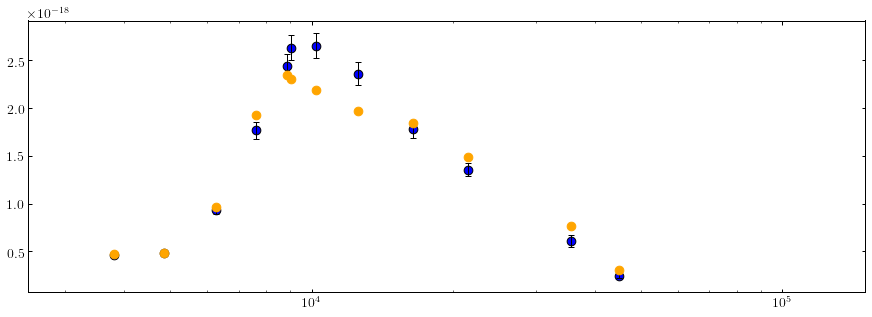

In [24]:
import matplotlib.pyplot as plt

model_photometry = get_model_photometry(redshifts[best_point[0]], age_indices[best_point[2]], masses[best_point[1]])

plt.figure(figsize=(15, 5))
plt.errorbar(eff_wavs, fluxes, yerr=fluxerrs, lw=1.0, linestyle=" ", capsize=3, capthick=1, color="black")
plt.scatter(eff_wavs, fluxes, s=75, linewidth=1, facecolor="blue", edgecolor="black")
plt.scatter(eff_wavs, model_photometry, s=75, facecolor="orange", zorder=10)
plt.xscale("log")
plt.xlim(1000.*(1 + redshift), 60000.*(1 + redshift))
plt.show()

This answer, whilst obviously wrong, isn't half bad given the simplifying assumptions we've made. I believe the spectroscopic redshift from Lega-C is aro